In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

(2225, 3)


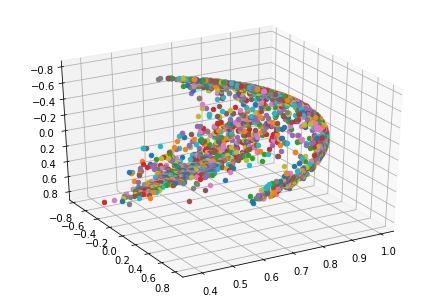

In [2]:
all_texts=[]
Y = []
# os.chdir("C://Users//Hp//Desktop//Projects//Text Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
print(vectors_dense_svd.shape)
fig=plt.figure()
ax = Axes3D(fig)
X = vectors_dense_svd
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 120)

In [3]:
max_iter = 100 #Maximum number of iterations
N = 12         #Population size (In the range 5 to 12)
K = 5         #Number of clusters

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        N wolves of length K*D where D is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated N times
    '''
    wolves_pack=[]
    for i in range(N):
        wolf=[]
        for j in range(K):
            wolf.append(X[random.randint(0,len(X)-1)])
        wolf=list(itertools.chain(*wolf))
        wolves_pack.append(wolf)
    return wolves_pack

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(wolf):
    '''
    Input : wolf -> A 1 x d(number of documents) vector containing the initial population
    Output: theta -> Fitness value of each wolf
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
#         clusters[cosine_similarity(centers,X[i])].append(X[i])
        
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
    
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    wolf =[]
    for i in range(len(centers)):
        wolf.extend(centers[i])
    fitness_score = theta
    return fitness_score,wolf

In [8]:
def fitness_evaluation(wolves):
    '''
    Input: wolves -> A N x d dimension matrix containing wolves
    Output:fitness-> A N x 1 dimension vector containing fitness values of all wolves
    '''
    fitness = []
    new_wolves=[]
    for i in range(len(wolves)):
        fit,wolf = fitness_function(wolves[i])
        fitness.append(fit)
        new_wolves.append(wolf)
    return fitness,new_wolves

In [9]:
def find_beta(wolves, fitness):
    alpha = max(fitness)
    beta  = -1000
    for i in fitness:
        if beta<i and i!=alpha:
            beta = i
    return wolves[fitness.index(beta)]

In [10]:
def find_gamma(wolves,fitness, beta):
    alpha = max(fitness)
    gamma = -10000
    for i in fitness:
        if gamma<i and i!=alpha and i!=beta:
            gamma = i
    return wolves[fitness.index(gamma)]

In [11]:
def grey_wolf_optimization():
    wolves = population_initialization()
    fitness,wolves= fitness_evaluation(wolves)
    alpha  = wolves[fitness.index(max(fitness))] 
    beta   = find_beta(wolves, fitness)
    gamma  = find_gamma(wolves, fitness, fitness[wolves.index(beta)])
    
    a = 2
    
    C1 = 2*np.random.random(size = len(alpha))
    C2 = 2*np.random.random(size = len(beta))
    C3 = 2*np.random.random(size = len(gamma))
    
    A1 = 2*a*np.random.random(size = len(alpha)) - a 
    A2 = 2*a*np.random.random(size = len(beta)) - a
    A3 = 2*a*np.random.random(size = len(gamma)) - a
    
    t = 1
    while t<max_iter:
        for i in wolves:
            if i!=alpha and i!=beta and i!=gamma:
                D_alpha = np.linalg.norm(np.dot(C1,alpha)-i)
                D_beta  = np.linalg.norm(np.dot(C2,beta)-i)
                D_gamma = np.linalg.norm(np.dot(C3,gamma)-i)

                X1 = alpha - A1*D_alpha
                X2 = beta - A2*D_beta
                X3 = gamma - A3*D_gamma

                i = (X1+X2+X3)/3
        #-----------------------------------------------------
        a = 2 - t*(2/max_iter)
        
        C1 = 2*np.random.random(size = len(alpha))
        C2 = 2*np.random.random(size = len(beta))
        C3 = 2*np.random.random(size = len(gamma))

        A1 = 2*a*np.random.random(size = len(alpha)) - a 
        A2 = 2*a*np.random.random(size = len(beta)) - a
        A3 = 2*a*np.random.random(size = len(gamma)) - a
        
        t = t + 1
        
        fitnes, wolves = fitness_evaluation(wolves)
        print("Generation "+ str(t) + ": "+str(max(fitnes)))
        alpha  = wolves[fitnes.index(max(fitnes))] 
        beta   = find_beta(wolves, fitnes)
        gamma  = find_gamma(wolves, fitnes, fitnes[wolves.index(beta)])
    
    return alpha

In [12]:
def intracluster_distances(wolf):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [13]:
def davies_bouldin_index(wolf):
    intra_distance = intracluster_distances(wolf)
    
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [14]:
def silhoutette_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [15]:
def dunn_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(wolf))
    return numerator/denominator

In [16]:
def supervised_scores(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(Y_pred)
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [17]:
def plot(wolf):
    centers=[]
    
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
   #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[cosine_similarity(centers,X[i])].append(X[i])
        clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#dd6622','#84ff33','#33ffee','#3395ff','#d2a8fc','#ffffff']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)

Generation 2: 8.196797660859579
Generation 3: 8.12055494434581
Generation 4: 6.358426082666897
Generation 5: 3.7596713646099267
Generation 6: 4.368631684327702
Generation 7: 4.178541347427735
Generation 8: 4.119780525892061
Generation 9: 4.7277335044103275
Generation 10: 4.6573842961183
Generation 11: 4.666972127490238
Generation 12: 4.6566175877598335
Generation 13: 4.668250492703543
Generation 14: 4.647897115915366
Generation 15: 4.601741168691533
Generation 16: 4.555567177952179
Generation 17: 4.468784783034003
Generation 18: 4.391285482872938
Generation 19: 4.291732546903171
Generation 20: 4.226291170489629
Generation 21: 4.146903835321498
Generation 22: 5.214673366624701
Generation 23: 4.207187934747598
Generation 24: 3.7382381074710986
Generation 25: 7.063624286255149
Generation 26: 6.499601715059643
Generation 27: 3.7407066804456304
Generation 28: 3.7382381074710813
Generation 29: 3.7382381074710773
Generation 30: 3.738238107471083
Generation 31: 3.7382381074710853
Generation 32

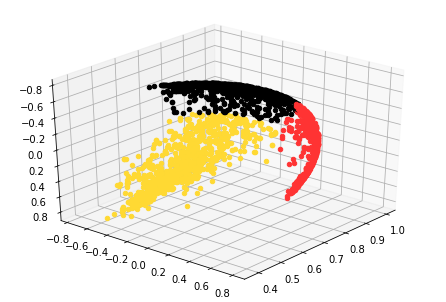

In [18]:
K = 3
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Dunn Index      :"+str(dunn_index(alpha)))
# F1, Accuracy = supervised_scores(alpha)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(alpha)

Generation 2: 15.067429754752553
Generation 3: 11.384128160482117
Generation 4: 11.53823662365975
Generation 5: 11.608485237916549
Generation 6: 11.276404255625915
Generation 7: 11.832805792560954
Generation 8: 10.743894316694416
Generation 9: 13.899889861862253
Generation 10: 13.091109517281163
Generation 11: 12.795310985006148
Generation 12: 10.358849220106046
Generation 13: 10.239082682384282
Generation 14: 10.182748846668806
Generation 15: 10.09382020179959
Generation 16: 10.029158510826267
Generation 17: 9.722916877563911
Generation 18: 9.652622473470851
Generation 19: 9.65262247347096
Generation 20: 9.652622473471
Generation 21: 9.652622473470982
Generation 22: 9.652622473471016
Generation 23: 9.652622473471004
Generation 24: 9.652622473471025
Generation 25: 9.652622473471073
Generation 26: 9.652622473470927
Generation 27: 9.65262247347098
Generation 28: 9.652622473470977
Generation 29: 9.652622473471032
Generation 30: 9.652622473470974
Generation 31: 9.65262247347104
Generation 

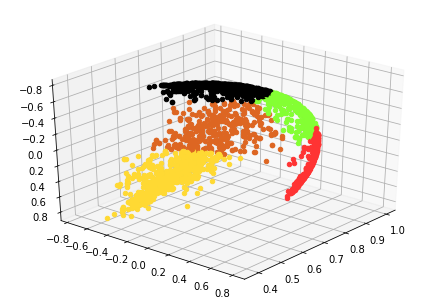

In [19]:
K = 5
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Dunn Index      :"+str(dunn_index(alpha)))
# F1, Accuracy = supervised_scores(alpha)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(alpha)

Generation 2: 20.16349849909071
Generation 3: 21.144708882695483
Generation 4: 17.31093327279482
Generation 5: 17.591771610001764
Generation 6: 20.30328487950949
Generation 7: 19.969342878228936
Generation 8: 20.279936455890713
Generation 9: 20.50544552799792
Generation 10: 20.269690563466447
Generation 11: 21.15893213189492
Generation 12: 20.99645901025239
Generation 13: 20.388940407094324
Generation 14: 19.626868636181605
Generation 15: 18.589286020318397
Generation 16: 18.582293943746343
Generation 17: 18.744898769526586
Generation 18: 18.76136075964683
Generation 19: 18.64555352700646
Generation 20: 18.517984228302392
Generation 21: 18.50991798597278
Generation 22: 18.502890464900613
Generation 23: 18.42563848047108
Generation 24: 18.42257662591249
Generation 25: 18.422576625912413
Generation 26: 18.42257662591241
Generation 27: 18.422576625912527
Generation 28: 18.422576625912388
Generation 29: 18.422576625912416
Generation 30: 18.42257662591245
Generation 31: 18.42257662591258
Ge

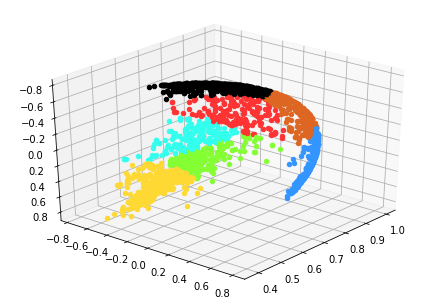

In [20]:
K = 7
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Dunn Index      :"+str(dunn_index(alpha)))
# F1, Accuracy = supervised_scores(alpha)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(alpha)

Generation 2: 31.151099956938577
Generation 3: 30.635606713162904
Generation 4: 29.656133852766555
Generation 5: 29.713291104994823
Generation 6: 26.560538587016712
Generation 7: 23.741565426755034
Generation 8: 22.781411813248702
Generation 9: 23.161768902547443
Generation 10: 22.984842976550144
Generation 11: 22.852775431402485
Generation 12: 23.186428370898497
Generation 13: 23.185830681077654
Generation 14: 24.689810341936617
Generation 15: 23.112653857367665
Generation 16: 23.093493878708035
Generation 17: 23.090914674315478
Generation 18: 23.09091467431537
Generation 19: 23.094724461867965
Generation 20: 23.195855277728356
Generation 21: 23.09091467431543
Generation 22: 23.0909146743154
Generation 23: 23.090914674315382
Generation 24: 23.090914674315453
Generation 25: 23.090914674315215
Generation 26: 23.090914674315307
Generation 27: 23.090914674315442
Generation 28: 23.090914674315478
Generation 29: 23.0909146743155
Generation 30: 23.0909146743154
Generation 31: 23.090914674315

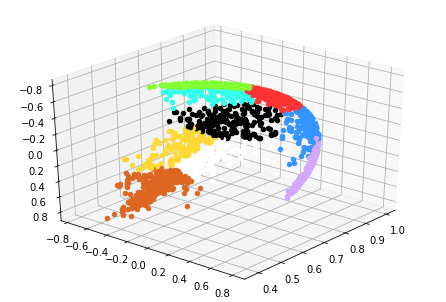

In [21]:
K = 9
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Dunn Index      :"+str(dunn_index(alpha)))
# F1, Accuracy = supervised_scores(alpha)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(alpha)